In [1]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import resample
import glob
import pywt

def WTfilt_1d(sig):
   
    coeffs = pywt.wavedec(sig, 'db6', level=9)
    coeffs[-1] = np.zeros(len(coeffs[-1]))
    coeffs[-2] = np.zeros(len(coeffs[-2]))
    coeffs[0] = np.zeros(len(coeffs[0]))
    sig_filt = pywt.waverec(coeffs, 'db6')
    return sig_filt


def heartbeat(file0):
    
    N_Seg=[]; SVEB_Seg=[];  VEB_Seg=[]; F_Seg=[] ; Q_Seg=[];
    De_file=[panth[:-1]+'/102.hea',panth[:-1]+'/104.hea',panth[:-1]+'/107.hea',panth[:-1]+'/217.hea']
    file=list(set(file0).difference(set(De_file)))
    print(file)
    print(len(file))
    for f in range(len(file)) :
        print(f)
        print(file[f])
        annotation= wfdb.rdann(panth+file[f][-7:-4],'atr')
        record_name=annotation.record_name    
        Record=wfdb.rdsamp(panth+record_name)[0][:,0] 
        record=WTfilt_1d(Record)         
        label=annotation.symbol  
        label_index=annotation.sample   
        for j in range(len(label_index)):
            if label_index[j]>=144  and (label_index[j]+180)<=650000:
                if label[j]=='N' or label[j]=='.' or label[j]=='L' or label[j]=='R' or label[j]=='e' or label[j]=='j':
                    Seg=record[label_index[j]-144:label_index[j]+180]
                    segment=resample(Seg,251, axis=0)  
                    N_Seg.append(segment)

                if label[j]=='A' or label[j]=='a' or label[j]=='J' or label[j]=='S':

                    Seg=record[label_index[j]-144:label_index[j]+180]
                    segment=resample(Seg,251, axis=0)
                    SVEB_Seg.append(segment)

                if label[j]=='V' or label[j]=='E':

                    Seg=record[label_index[j]-144:label_index[j]+180]
                    segment=resample(Seg,251, axis=0)
                    VEB_Seg.append(segment)

                if label[j]=='F':

                    Seg=record[label_index[j]-144:label_index[j+1]+180]
                    segment=resample(Seg,251, axis=0)
                    F_Seg.append(segment)
                if  label[j]=='/' or label[j]=='f' or label[j]=='Q':

                    Seg=record[label_index[j]-144:label_index[j]+180]
                    segment=resample(Seg,251, axis=0)
                    Q_Seg.append(segment)

    N_segement=np.array(N_Seg)
    SVEB_segement=np.array(SVEB_Seg)
    VEB_segement=np.array(VEB_Seg)
    F_segement=np.array(F_Seg)
    Q_segement=np.array(Q_Seg)

    label_N=np.zeros(N_segement.shape[0])
    label_SVEB=np.ones(SVEB_segement.shape[0])
    label_VEB=np.ones(VEB_segement.shape[0])*2
    label_F=np.ones(F_segement.shape[0])*3
    label_Q=np.ones(Q_segement.shape[0])*4
    
    

    Data=np.concatenate((N_segement,SVEB_segement,VEB_segement,F_segement,Q_segement),axis=0)
    Label=np.concatenate((label_N,label_SVEB,label_VEB,label_F,label_Q),axis=0)
    


    return  Data, Label

panth='C:/Users/alaas/Desktop/mit_database/MIT_BIH/'
file = glob.glob(panth+'*.hea')
print(len(file))
print(file)
Data, Label=heartbeat(file)

Data=np.save('C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased/'+'Data',Data)
Label=np.save('C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased/'+'Label',Label)

C:\Users\alaas\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


48
['C:/Users/alaas/Desktop/mit_database/MIT_BIH\\100.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\101.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\102.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\103.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\104.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\105.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\106.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\107.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\108.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\109.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\111.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\112.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\113.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\114.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\115.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\116.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH\\117.hea', 'C:/Users/alaas/Desktop/mit_database/MIT_BIH

In [2]:
import numpy as np
import keras_tuner
import keras
from keras import backend as K
from tensorflow.keras import regularizers
from keras.layers import MaxPooling1D,AveragePooling1D,Conv1D,MaxPool1D,add,Flatten,Dense,Concatenate,Activation, Bidirectional, LSTM, Dropout
import random
from keras.models import Sequential,load_model,Model


def model_new(inputs1):
    
    conv11 = Conv1D(filters=40, kernel_size=2, padding='Same', activation='tanh', kernel_initializer="he_uniform", strides=1, 
                    use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(inputs1)
    pool11 = MaxPool1D(pool_size=2)(conv11)
    dropout11 = Dropout(0.1)(pool11)
    

    conv22 = Conv1D(filters=60, kernel_size=3, padding='Same', activation='tanh', kernel_initializer="he_uniform", strides=1, 
                    use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(dropout11)
    pool22 = MaxPool1D(pool_size=3)(conv22)
    dropout22 = Dropout(0.1)(pool22)

    
    conv33 = Conv1D(filters=80, kernel_size=4, padding='Same', activation='tanh', kernel_initializer="he_uniform", strides=1, 
                    use_bias=False, kernel_regularizer=regularizers.l2(0.0001))(dropout22)
    pool33 = MaxPool1D(pool_size=4)(conv33)
    dropout33 = Dropout(0.1)(pool33)

    bi1 = Bidirectional(LSTM(units=50, return_sequences=False))(dropout33)

    res = Dense(5, activation="softmax")(bi1)
    res = Model(inputs=inputs1, outputs=res, name="ResNet")
    return res


def shuffle_set(data,label):
    train_row = list(range(len(label)))
    random.shuffle(train_row)
    Data = data[train_row]
    Label = label[train_row]
    return Data,Label

In [3]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale
from keras.layers import Input
from keras  import optimizers
import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import MaxPooling1D,AveragePooling1D,Conv1D,MaxPool1D,add,Flatten,Dense,Concatenate,Activation, Input
import random
import keras.regularizers
from keras.models import Sequential,load_model,Model
from tensorflow.keras.models import Model
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import resample
import glob
import pywt
from keras import backend as K
from tensorflow.keras import regularizers
from keras.layers import MaxPooling1D,AveragePooling1D,Conv1D,MaxPool1D,add,Flatten,Dense,Concatenate,Activation
import random
from keras.models import Sequential,load_model,Model
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale
from keras.layers import Input
from keras  import optimizers
import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn import metrics
from sklearn.metrics import classification_report
from re import L
import pandas as pd
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE



data=np.load('C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased/Data.npy')
label=np.load('C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased/Label.npy')


C:\Users\alaas\AppData\Local\Temp\ipykernel_9380\559173783.py:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


(array([90587.,     0.,  2781.,     0.,     0.,  7235.,     0.,   802.,
            0.,  8038.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

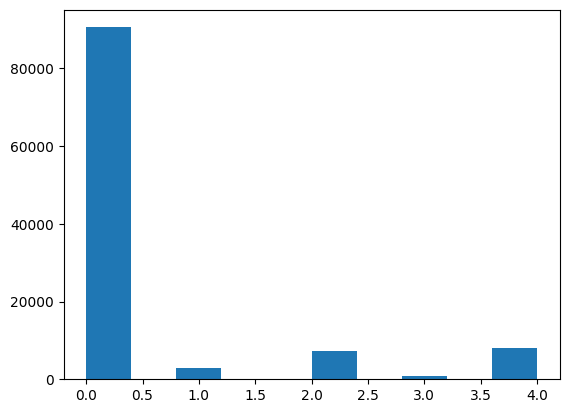

In [4]:
plt.hist(label)

In [5]:
data.shape

(109443, 251)

In [6]:
label.shape

(109443,)

(array([90587.,     0., 90587.,     0.,     0., 90587.,     0., 90587.,
            0., 90587.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

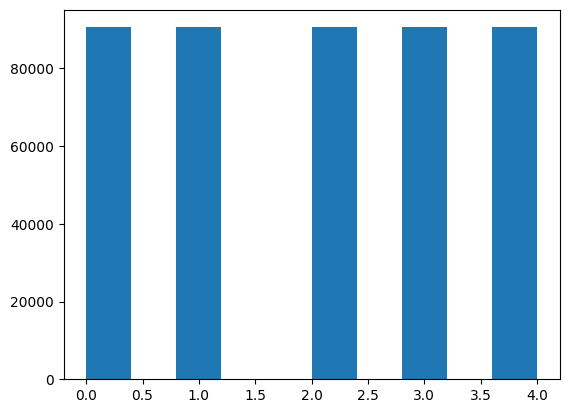

In [7]:
# Data Balancing for Multi Classification


data_reshaped = data.reshape(np.shape(data)[0:2])

smote = SMOTE(sampling_strategy='auto',random_state=40,k_neighbors=4)
data_balanced, label_balanced = smote.fit_resample(data_reshaped, label)


plt.hist(label_balanced)

In [8]:
from sklearn.model_selection import train_test_split


data_80, data_20, label_80, label_20 = train_test_split(data_balanced, label_balanced, test_size=0.2, random_state=40)

(array([72464.,     0., 72480.,     0.,     0., 72441.,     0., 72392.,
            0., 72571.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

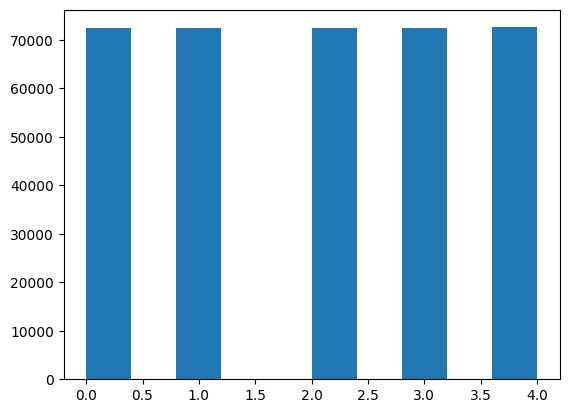

In [9]:
plt.hist(label_80)

(array([18123.,     0., 18107.,     0.,     0., 18146.,     0., 18195.,
            0., 18016.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

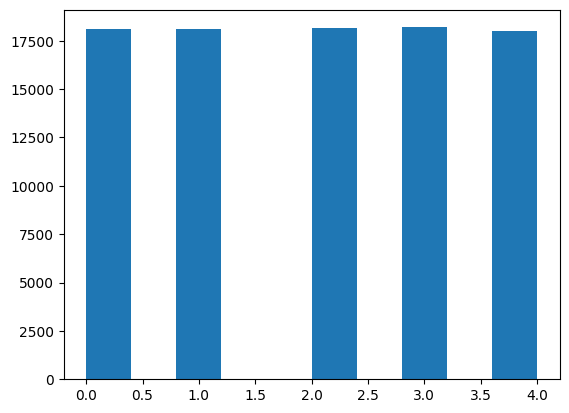

In [10]:
plt.hist(label_20)

In [11]:
data_80.shape

(362348, 251)

In [12]:
label_80.shape

(362348,)

In [13]:
label_80

array([4., 4., 3., ..., 3., 4., 4.])

In [14]:
# here we do the binary model first               # we have data_binary, label_binary

In [15]:
data_binary = data_80

In [16]:
label_binary = np.zeros((362348,))
for i in range(len(label_binary)):
    if(label_80[i] == 0):
        label_binary[i] = 0
    else:
        label_binary[i] = 1

(array([ 72464.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 289884.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

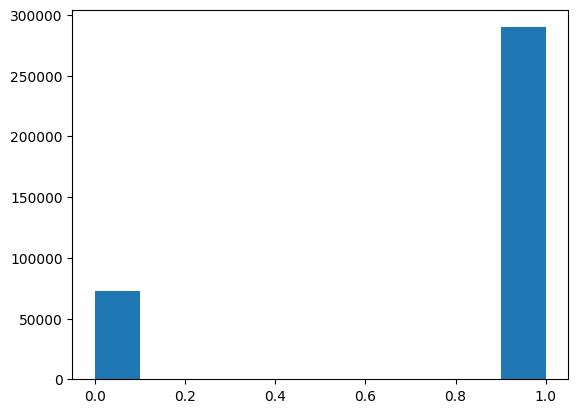

In [17]:
plt.hist(label_binary)

In [18]:
label_binary.shape

(362348,)

In [19]:
data_binary.shape

(362348, 251)

(array([289884.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 289884.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

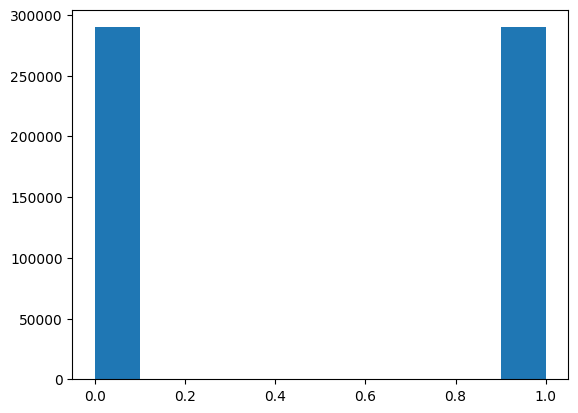

In [20]:
# Data Balancing for Binary Classification
from imblearn.over_sampling import SMOTE

binary_smote = SMOTE(sampling_strategy='auto', random_state = 40, k_neighbors = 4)
binary_data_balanced, binary_label_balanced = binary_smote.fit_resample(data_binary, label_binary)


Data_Binary, Label_Binary = shuffle_set(binary_data_balanced, binary_label_balanced)
plt.hist(binary_label_balanced)

# we UNDER SAMPLE THE DATA BECAUSE IT'S TOO BIG

(array([289884.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 289884.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

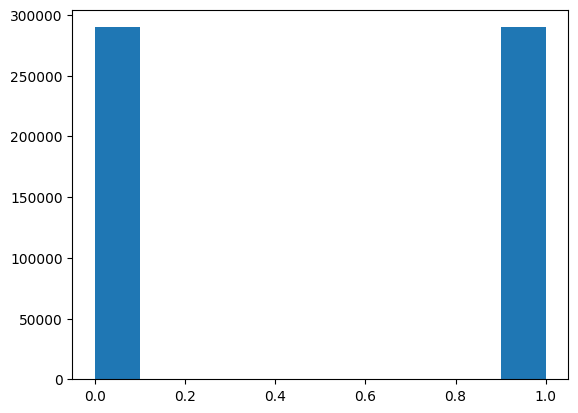

In [21]:
plt.hist(Label_Binary)

In [22]:
Label_Binary.shape

(579768,)

In [23]:
Data_Binary.shape

(579768, 251)

In [24]:
Data_Binary[3]

array([-8.88355012e-02, -7.42195286e-02, -7.81826706e-02, -7.84595503e-02,
       -9.22690459e-02, -1.03217056e-01, -1.09810980e-01, -9.92563981e-02,
       -8.34704743e-02, -7.25051163e-02, -7.33230381e-02, -8.07632409e-02,
       -8.44046182e-02, -8.39771494e-02, -8.15560733e-02, -8.25754409e-02,
       -8.66861973e-02, -9.11170280e-02, -9.31357021e-02, -8.96840853e-02,
       -8.27461008e-02, -7.74238138e-02, -7.84398952e-02, -8.58867810e-02,
       -9.18419443e-02, -9.13599555e-02, -8.36846883e-02, -7.49264523e-02,
       -6.94760839e-02, -6.63914709e-02, -6.67515685e-02, -6.96520831e-02,
       -8.03792878e-02, -9.12256191e-02, -9.79843133e-02, -9.37460564e-02,
       -8.44043312e-02, -7.55703982e-02, -6.76050825e-02, -6.20509394e-02,
       -5.90841285e-02, -6.55530409e-02, -7.76528463e-02, -8.63552121e-02,
       -8.66702910e-02, -7.82431695e-02, -7.21411400e-02, -6.63862690e-02,
       -6.34053029e-02, -5.97976101e-02, -6.06615686e-02, -6.64919228e-02,
       -7.36342785e-02, -

In [25]:
# Count the number of zeros
num_zeros = np.count_nonzero(Label_Binary==0)

# Calculate the number of zeros to keep
num_zeros_to_keep = int(num_zeros * (1 - 0.7)) # where 0.7 is the ratio we want to keep the zeros, can be adjusted

# Get indices of zeros
zeros_indices = np.where(Label_Binary == 0)[0]

# Randomly select indices to delete
delete_indices = np.random.choice(zeros_indices, num_zeros - num_zeros_to_keep, replace=False)

# Set the selected indices to zero
Label_Binary = np.delete(Label_Binary, delete_indices)
Data_Binary = np.delete(Data_Binary, delete_indices, axis=0)

(array([ 86965.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 289884.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

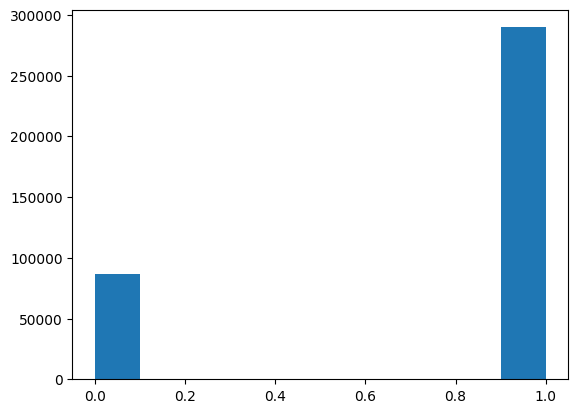

In [26]:
plt.hist(Label_Binary)

In [27]:
Label_Binary.shape

(376849,)

In [28]:
Data_Binary.shape

(376849, 251)

In [29]:
def build_model(inputs1):
    Dense1 = Dense(102, activation="relu")(inputs1)
    Dense2 = Dense(50, activation="relu")(Dense1)
    res = Dense(1, activation="sigmoid")(Dense2)
    res = Model(inputs=inputs1, outputs=res, name="ResNet")
    return res

In [30]:
Con_Matr_binary=[]  
F1_binary=[]        
Acc_binary=[]       
Acc_history_binary=[]
Loss_binary=[]      
Loss_history_binary=[]
Val_Acc_binary = []
Val_Loss_binary =[]

X_train, X_test, y_train, y_test = train_test_split(Data_Binary, Label_Binary, test_size=0.2, random_state=40)
inputs1 = Input(shape=(251,))
model_binary = build_model(inputs1)
model_binary.summary()
model_binary.compile(loss='binary_crossentropy', optimizer='adam',
                  # metrics=['accuracy',f1_m,precision_m, recall_m]
                  metrics=['binary_accuracy']
                 )

filepath="C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased/best_binary_model_lstm_bwm_knn_biased.hdf5"

checkpoint = ModelCheckpoint(filepath, verbose=2,
                          monitor='val_binary_accuracy', mode='max',
                         save_best_only='True')

callback_lists = [checkpoint]

result = model_binary.fit(X_train, y_train, validation_data=(X_test,y_test), class_weight = None,
                callbacks=callback_lists, epochs=100,batch_size=64)


Val_Acc_binary.append(result.history['val_binary_accuracy'])
Val_Loss_binary.append(result.history['val_loss'])
Acc_history_binary.append(result.history['binary_accuracy'])
Loss_history_binary.append(result.history['loss'])


# save the model

import pickle

# save the iris classification model as a pickle file
model_pkl_file = "C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased/best_binary_model_lstm_bwm_knn_biased.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model_binary, file)


inputs1=Input(shape=(251,))

model_binary = build_model(inputs1)

model_binary.load_weights(filepath)

model_binary.compile(loss='binary_crossentropy', optimizer='adam',
                  # metrics=['accuracy',f1_m,precision_m, recall_m]
                  metrics=['binary_accuracy']
                 )

#Evaluate the model with the metrics  we defined earlier
loss,accuracy = model_binary.evaluate(X_test,y_test)

Acc_binary.append(accuracy)
Loss_binary.append(loss)

y_pred = model_binary.predict(X_test).round()


Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 251)]             0         
                                                                 
 dense (Dense)               (None, 102)               25704     
                                                                 
 dense_1 (Dense)             (None, 50)                5150      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30905 (120.72 KB)
Trainable params: 30905 (120.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch 1/100


4665/4711 [============================>.] - ETA: 0s - loss: 0.0615 - binary_accuracy: 0.9780
Epoch 1: val_binary_accuracy improved from -

C:\Users\alaas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4689/4711 [============================>.] - ETA: 0s - loss: 0.0237 - binary_accuracy: 0.9921
Epoch 2: val_binary_accuracy improved from 0.99077 to 0.99419, saving model to C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased\best_binary_model_lstm_bwm_knn_biased.hdf5
4711/4711 [==============================] - 6s 1ms/step - loss: 0.0237 - binary_accuracy: 0.9921 - val_loss: 0.0177 - val_binary_accuracy: 0.9942
Epoch 3/100
4701/4711 [============================>.] - ETA: 0s - loss: 0.0167 - binary_accuracy: 0.9947
Epoch 3: val_binary_accuracy improved from 0.99419 to 0.99491, saving model to C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased\best_binary_model_lstm_bwm_knn_biased.hdf5
4711/4711 [==============================] - 6s 1ms/step - loss: 0.0167 - binary_accuracy: 0.9947 - val_loss: 0.0158 - val_binary_accuracy: 0.9949
Epoch 4/100
4704/4711 [============================>.] - ETA: 0s - loss: 0.0138 - binary_accuracy: 0.9955
Epoch 4: val_binary_accuracy did not improve

In [31]:
y_pred

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [32]:
y_test

array([1., 1., 0., ..., 1., 1., 1.])

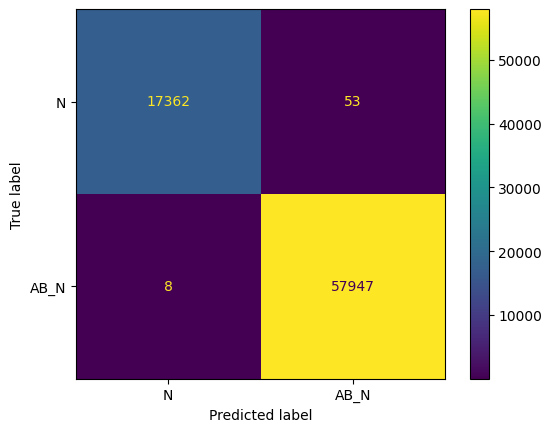

In [33]:
#evaluating model for binary Classifier

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['N', 'AB_N'])

cm_display.plot()
plt.show()

In [34]:
# Accuracy_Binary
# (True Positive + True Negative) / Total Predictions
Accuracy = metrics.accuracy_score(y_test, y_pred)
print(Accuracy)

0.9991906594135598


In [35]:
# Precision_Binary
# True Positive / (True Positive + False Positive)
Precision = metrics.precision_score(y_test, y_pred)
print(Precision)

0.9990862068965517


In [36]:
# Sensitivity_Binary
# True Positive / (True Positive + False Negative)
Sensitivity_recall = metrics.recall_score(y_test, y_pred)
print(Sensitivity_recall)

0.9998619618669657


In [37]:
# Specificity_Binary
# True Negative / (True Negative + False Positive)
from imblearn import metrics as m
Specificity = m.specificity_score(y_test, y_pred)
print(Specificity)

0.9969566465690497


In [38]:
# F1_SCORE_Binary
F1_score = metrics.f1_score(y_test, y_pred)
print(F1_score)

0.9994739338536502


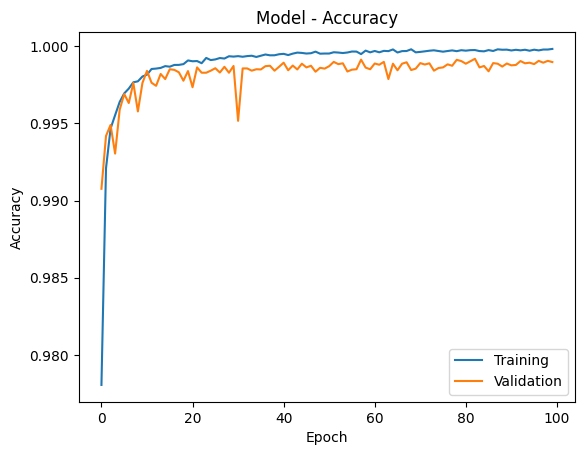

In [39]:
fig1, ax_acc = plt.subplots()

plt.plot(Acc_history_binary[0])
plt.plot(Val_Acc_binary[0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

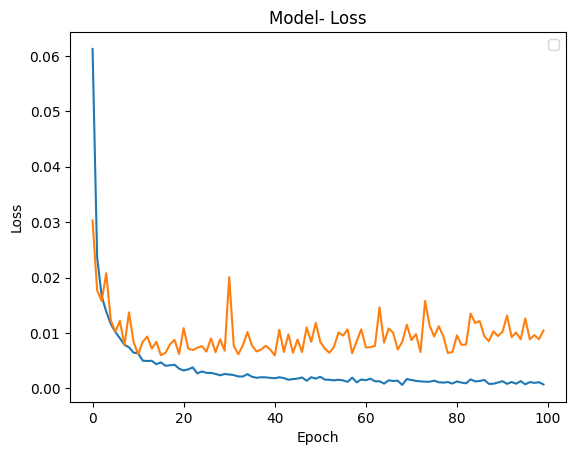

In [40]:
fig2, ax_loss = plt.subplots()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model- Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.plot(Loss_history_binary[0])
plt.plot(Val_Loss_binary[0])
plt.show()

In [41]:
def compute_conv1d_params(layer):
    return layer.kernel_size[0] * layer.filters

def compute_total_computations(model, input_shape):
    total_multiplications = 0
    total_additions = 0

    inputs = Input(shape=input_shape)
    model_instance = model(inputs)

    for layer in model.layers:
        if isinstance(layer, Conv1D):
            multiplications = compute_conv1d_params(layer) * layer.input_shape[1]
            total_multiplications += multiplications
            total_additions += (multiplications + layer.output_shape[1])  # For ReLU activations and bias
        elif isinstance(layer, Dense):
            multiplications = layer.input_shape[1] * layer.units
            total_multiplications += multiplications
            total_additions += (multiplications + layer.units)  # For bias additions

    return total_multiplications,total_additions

In [42]:
compute_total_computations(model_binary, (251,))

(30752, 30905)

In [43]:
# for multi_model

In [44]:
data_multi = data_80

In [45]:
label_multi = label_80

(array([72464.,     0., 72480.,     0.,     0., 72441.,     0., 72392.,
            0., 72571.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

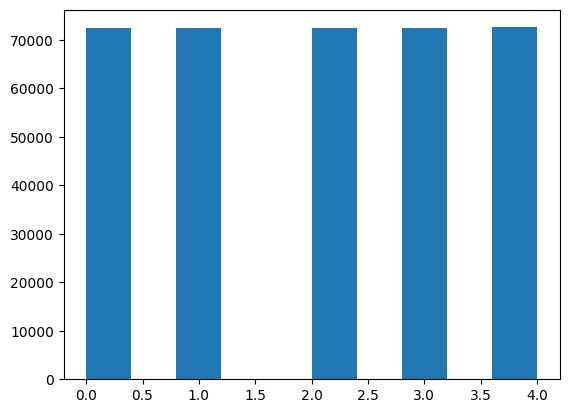

In [46]:
plt.hist(label_multi)

In [47]:
data_multi.shape

(362348, 251)

In [48]:
# Data Balancing for Multi Classification


smote = SMOTE(sampling_strategy='auto',random_state=40,k_neighbors=4)
data_balanced, label_balanced = smote.fit_resample(data_multi, label_multi)
data_exp = np.expand_dims(data_balanced, axis=2)
label_cat=to_categorical(label_balanced,5)


Data_Multi,Label_Multi= shuffle_set(data_exp,label_cat)

(array([72571.,     0., 72571.,     0.,     0., 72571.,     0., 72571.,
            0., 72571.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

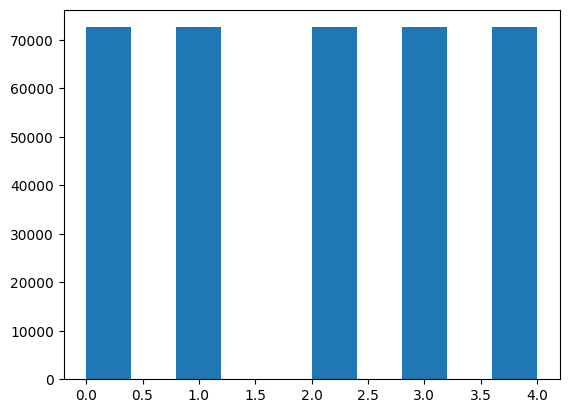

In [49]:
plt.hist(label_balanced)

In [50]:
Label_Multi.shape

(362855, 5)

In [51]:
Data_Multi.shape

(362855, 251, 1)

In [52]:
import numpy as np
import keras_tuner
import keras
from keras import backend as K
from tensorflow.keras import regularizers
from keras.layers import MaxPooling1D,AveragePooling1D,Conv1D,MaxPool1D,add,Flatten,Dense,Concatenate,Activation, Bidirectional, LSTM, Dropout
import random
from keras.models import Sequential,load_model,Model

In [53]:
# for Multi_Model

Con_Matr=[]  
F1=[]        
Acc=[]      
Acc_history=[]
Loss=[]      
Loss_history=[]
Val_Acc = []
Val_Loss =[]

X_train1,X_test1,y_train1,y_test1 = train_test_split(Data_Multi,Label_Multi, test_size=0.2, random_state=40) # 0.2 test, 0,8 train
print(y_train1.shape)
print(X_train1.shape)
inputs1=Input(shape=(251,1) )
model = model_new(inputs1)
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy']
              )

filepath="C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased/best_model_lstm_bwm_knn_biased.hdf5"

checkpoint = ModelCheckpoint(filepath, verbose=2,
                          monitor='val_categorical_accuracy', mode='max',
                         save_best_only='True')


callback_lists = [checkpoint]


history = model.fit(X_train1, y_train1, validation_data=(X_test1,y_test1), class_weight = None,
                callbacks=callback_lists, epochs=100,batch_size=64)
#How to Make the class_weight Balanced or auto!!!!!



Val_Acc.append(history.history['val_categorical_accuracy'])
Val_Loss.append(history.history['val_loss'])
Acc_history.append(history.history['categorical_accuracy'])
Loss_history.append(history.history['loss'])

# save the model

import pickle

# save the iris classification model as a pickle file
model_pkl_file = "C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased/best_model_lstm_bwm_knn_biased.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)



inputs1=Input(shape=(251,1) )

model = model_new(inputs1)

model.load_weights(filepath)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy']
              )
print(f'\ntesting{i}.....')

#Evaluate the model with the metrics  we defined earlier
loss,accuracy = model.evaluate(X_test1,y_test1)

Acc.append(accuracy)
Loss.append(loss)

y_pred1 = model.predict(X_test1)

(290284, 5)
(290284, 251, 1)

Model: "ResNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 251, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 251, 40)           80        
                                                                 
 max_pooling1d (MaxPooling1  (None, 125, 40)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 125, 40)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 60)           7200      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 60)            0         
 g1D)                         

C:\Users\alaas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4530/4536 [============================>.] - ETA: 0s - loss: 0.0537 - categorical_accuracy: 0.9892
Epoch 2: val_categorical_accuracy improved from 0.98982 to 0.99128, saving model to C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased\best_model_lstm_bwm_knn_biased.hdf5
4536/4536 [==============================] - 41s 9ms/step - loss: 0.0537 - categorical_accuracy: 0.9892 - val_loss: 0.0447 - val_categorical_accuracy: 0.9913
Epoch 3/100
4530/4536 [============================>.] - ETA: 0s - loss: 0.0375 - categorical_accuracy: 0.9926
Epoch 3: val_categorical_accuracy improved from 0.99128 to 0.99409, saving model to C:/Users/alaas/Downloads/conference/lstm_bwm_knn_biased\best_model_lstm_bwm_knn_biased.hdf5
4536/4536 [==============================] - 41s 9ms/step - loss: 0.0375 - categorical_accuracy: 0.9926 - val_loss: 0.0329 - val_categorical_accuracy: 0.9941
Epoch 4/100
4531/4536 [============================>.] - ETA: 0s - loss: 0.0305 - categorical_accuracy: 0.9939
Epoch 4: va

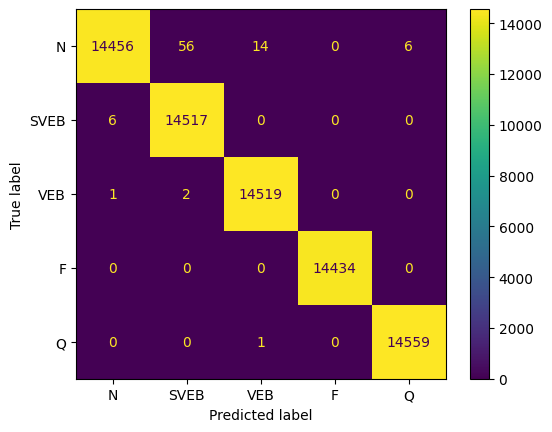

In [54]:
from sklearn import metrics

y_test1_cm=np.argmax(y_test1,axis=1)
y_pred1_cm=np.argmax(y_pred1,axis=1)

confusion_matrix = metrics.confusion_matrix(y_test1_cm, y_pred1_cm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['N', 'SVEB', 'VEB', 'F', 'Q'])

cm_display.plot()
plt.show()

In [55]:
# Accuracy
# (True Positive + True Negative) / Total Predictions
Accuracy = metrics.accuracy_score(y_test1_cm, y_pred1_cm)
print(Accuracy)

0.998814953631616


In [56]:
# Precision
# True Positive / (True Positive + False Positive)
Precision = metrics.precision_score(y_test1_cm, y_pred1_cm, average='macro')
print(Precision)

0.9988185160710152


In [57]:
# Sensitivity
# True Positive / (True Positive + False Negative)
Sensitivity_recall = metrics.recall_score(y_test1_cm, y_pred1_cm, average='macro')
print(Sensitivity_recall)

0.9988163520369631


In [58]:
# Specificity
# True Negative / (True Negative + False Positive)
from imblearn import metrics as m
Specificity = m.specificity_score(y_test1_cm, y_pred1_cm, average='macro')
print(Specificity)

0.9997036774602568


In [59]:
# F1_SCORE
F1_score = metrics.f1_score(y_test1_cm, y_pred1_cm, average='macro')
print(F1_score)

0.9988156273737665


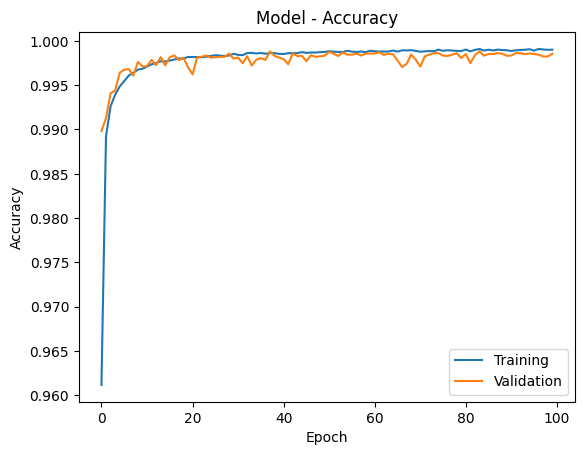

In [60]:
fig1, ax_acc = plt.subplots()

plt.plot(Acc_history[0])
plt.plot(Val_Acc[0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

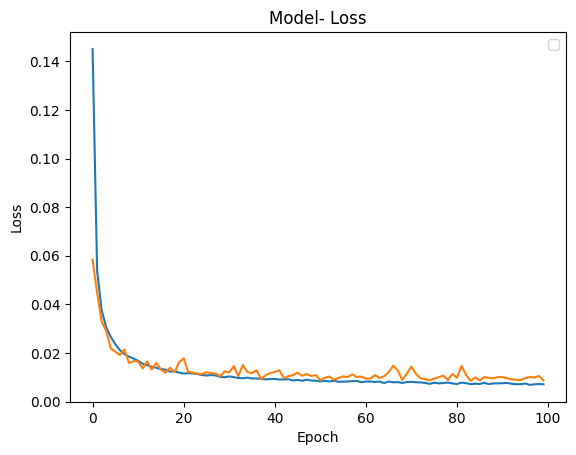

In [61]:
fig2, ax_loss = plt.subplots()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model- Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.plot(Loss_history[0])
plt.plot(Val_Loss[0])
plt.show()

In [62]:
data_20.shape

(90587, 251)

In [63]:
label_20.shape

(90587,)

In [ ]:
pred = np.zeros(shape=(data_20.shape[0], 5) )
for i in range(data_20.shape[0]):
    m = data_20[i].reshape(1,251)
    n = data_20[i].reshape(1,251,1)
    p = model_binary.predict(m)
    if(p == 0):
        pred[i] = np.array([1, 0, 0, 0, 0]) 
    else:
        q = model.predict(n)  # add counter
        pred[i] = q
    print(i)

1/1 [==============================] - 0s 3ms/step
0
1/1 [==============================] - 0s 0s/step
1
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 16ms/step
3
1/1 [==============================] - 0s 16ms/step
4
1/1 [==============================] - 0s 16ms/step
5
1/1 [==============================] - 0s 16ms/step
6
1/1 [==============================] - 0s 16ms/step
7
1/1 [==============================] - 0s 16ms/step
8
1/1 [==============================] - 0s 16ms/step
9
1/1 [==============================] - 0s 16ms/step
10
1/1 [==============================] - 0s 25ms/step
11
1/1 [==============================] - 0s 2ms/step
12
1/1 [==============================] - 0s 16ms/step
13
1/1 [==============================] - 0s 16ms/step
14
1/1 [==============================] - 0s 16ms/step
15
1/1 [==============================] - 0s 31ms/step
16
1/1 [==============================] - 0s 16ms/step
17
1/1 [===================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 18ms/step
14717
1/1 [==============================] - 0s 19ms/step
14718
1/1 [==============================] - 0s 18ms/step
14719
1/1 [==============================] - 0s 17ms/step
14720
1/1 [==============================] - 0s 18ms/step
14721
1/1 [==============================] - 0s 16ms/step
14722
1/1 [==============================] - 0s 17ms/step
14723
1/1 [==============================] - 0s 17ms/step
14724
1/1 [==============================] - 0s 18ms/step
14725
1/1 [==============================] - 0s 16ms/step
14726
1/1 [==============================] - 0s 18ms/step
14727
1/1 [==============================] - 0s 15ms/step
14728
1/1 [==============================] - 0s 17ms/step
14729
1/1 [==============================] - 0s 18ms/step
14730
1/1 [==============================] - 0s 16ms/step
14731
1/1 [==============================] - 0s 20ms/step
14732
1/1 [==============================] - 0s 22ms/step
14733
1/1 [=========

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 16ms/step
18398
1/1 [==============================] - 0s 15ms/step
18399
1/1 [==============================] - 0s 22ms/step
18400
1/1 [==============================] - 0s 22ms/step
18401
1/1 [==============================] - 0s 20ms/step
18402
1/1 [==============================] - 0s 21ms/step
18403
1/1 [==============================] - 0s 18ms/step
18404
1/1 [==============================] - 0s 16ms/step
18405
1/1 [==============================] - 0s 15ms/step
18406
1/1 [==============================] - 0s 17ms/step
18407
1/1 [==============================] - 0s 20ms/step
18408
1/1 [==============================] - 0s 20ms/step
18409
1/1 [==============================] - 0s 26ms/step
18410
1/1 [==============================] - 0s 26ms/step
18411
1/1 [==============================] - 0s 18ms/step
18412
1/1 [==============================] - 0s 19ms/step
18413
1/1 [==============================] - 0s 20ms/step
18414
1/1 [=========

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 17ms/step
27706
1/1 [==============================] - 0s 18ms/step
27707
1/1 [==============================] - 0s 13ms/step
28759
1/1 [==============================] - 0s 15ms/step
28760
1/1 [==============================] - 0s 16ms/step
28761
1/1 [==============================] - 0s 16ms/step
28762
1/1 [==============================] - 0s 19ms/step
28763
1/1 [==============================] - 0s 17ms/step
28764
1/1 [==============================] - 0s 15ms/step
28765
1/1 [==============================] - 0s 23ms/step
28766
1/1 [==============================] - 0s 23ms/step
28767
1/1 [==============================] - 0s 17ms/step
28768
1/1 [==============================] - 0s 15ms/step
28769
1/1 [==============================] - 0s 17ms/step
28770
1/1 [==============================] - 0s 19ms/step
28771
1/1 [==============================] - 0s 18ms/step
28772
1/1 [==============================] - 0s 15ms/step
28773
1/1 [=========

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



30559
1/1 [==============================] - 0s 17ms/step
30560
1/1 [==============================] - 0s 17ms/step
30561
1/1 [==============================] - 0s 17ms/step
30562
1/1 [==============================] - 0s 19ms/step
30563
1/1 [==============================] - 0s 17ms/step
30564
1/1 [==============================] - 0s 16ms/step
30565
1/1 [==============================] - 0s 19ms/step
30566
1/1 [==============================] - 0s 16ms/step
30567
1/1 [==============================] - 0s 16ms/step
30568
1/1 [==============================] - 0s 16ms/step
30569
1/1 [==============================] - 0s 20ms/step
30570
1/1 [==============================] - 0s 18ms/step
30571
1/1 [==============================] - 0s 18ms/step
30572
1/1 [==============================] - 0s 18ms/step
30573
1/1 [==============================] - 0s 19ms/step
30574
1/1 [==============================] - 0s 19ms/step
30575
1/1 [==============================] - 0s 17ms/step
30576
1/1 [===

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 22ms/step
40453
1/1 [==============================] - 0s 16ms/step
40454
1/1 [==============================] - 0s 18ms/step
40455
1/1 [==============================] - 0s 18ms/step
40456
1/1 [==============================] - 0s 18ms/step
40457
1/1 [==============================] - 0s 18ms/step
40458
1/1 [==============================] - 0s 19ms/step
40459
1/1 [==============================] - 0s 19ms/step
40460
1/1 [==============================] - 0s 15ms/step
40461
1/1 [==============================] - 0s 18ms/step
40462
1/1 [==============================] - 0s 18ms/step
40463
1/1 [==============================] - 0s 18ms/step
40464
1/1 [==============================] - 0s 18ms/step
40465
1/1 [==============================] - 0s 17ms/step
40466
1/1 [==============================] - 0s 16ms/step
40467
1/1 [==============================] - 0s 17ms/step
40468
1/1 [==============================] - 0s 17ms/step
40469
1/1 [=========

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 17ms/step
43598
1/1 [==============================] - 0s 17ms/step
43599
1/1 [==============================] - 0s 17ms/step
43600
1/1 [==============================] - 0s 16ms/step
43601
1/1 [==============================] - 0s 18ms/step
43602
1/1 [==============================] - 0s 17ms/step
43603
1/1 [==============================] - 0s 18ms/step
43604
1/1 [==============================] - 0s 17ms/step
43605
1/1 [==============================] - 0s 17ms/step
43606
1/1 [==============================] - 0s 17ms/step
43607
1/1 [==============================] - 0s 18ms/step
43608
1/1 [==============================] - 0s 18ms/step
43609
1/1 [==============================] - 0s 19ms/step
43610
1/1 [==============================] - 0s 18ms/step
43611
1/1 [==============================] - 0s 17ms/step
43612
1/1 [==============================] - 0s 18ms/step
43613
1/1 [==============================] - 0s 17ms/step
43614
1/1 [=========

In [74]:
pred.shape

(90587, 5)

In [ ]:
pred

In [75]:
label_20.shape

(90587,)

In [ ]:
#label_20=to_categorical(label_20,5) #TO BE PUT

In [76]:
# Find the maximum value in each row
max_values = np.max(pred, axis = 1)

# Create a new array with the same shape filled with zeros
result_array = np.zeros_like(pred)

# Set elements to 1 where they match the maximum value in each row
for i in range(pred.shape[0]):  # Loop through rows
    if max_values[i] == 0:
        result_array[i] = 0
    else:
        result_array[i][pred[i] == max_values[i]] = 1

print(result_array)

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]


In [77]:
result_array = result_array.astype(int)

In [78]:
label_20 = label_20.astype(int) # don't forget to reorder

In [79]:
result_array.dtype

dtype('int32')

In [80]:
label_20.dtype

dtype('int32')

In [82]:
label_20.shape # to be removed

(90587,)

In [83]:
label_20 # to be removed

array([3, 4, 2, ..., 1, 4, 1])

In [84]:
label_20 = to_categorical(label_20 ,5) # to be removed

In [86]:
label_20.shape # to be removed

(90587, 5)

In [89]:
label_20 = label_20.astype(int) # to be removed

In [90]:
label_20.dtype # to be removed

dtype('int32')

In [91]:
xored = np.bitwise_xor(result_array, label_20)

In [92]:
xored

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [93]:
# Initialize sum
total_sum = 0

# Loop through the array
for row in xored:
    if 1 in row:
        total_sum += 1

print("Total sum:", total_sum)

Total sum: 139


In [94]:
total_accuracy = (xored.shape[0]-total_sum) / xored.shape[0]
print(total_accuracy)

0.9984655634914502


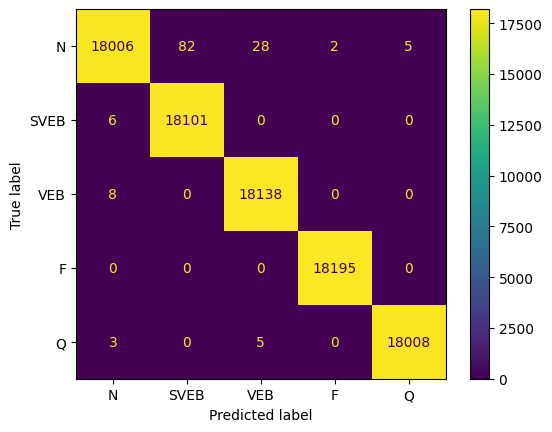

In [103]:
from sklearn import metrics

label_20_v=np.argmax(label_20,axis=1)
pred_v=np.argmax(pred,axis=1)

confusion_matrix = metrics.confusion_matrix(label_20_v, pred_v)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['N', 'SVEB', 'VEB', 'F', 'Q'])

cm_display.plot()
plt.show()

In [98]:
# Accuracy
# (True Positive + True Negative) / Total Predictions
Accuracy = metrics.accuracy_score(label_20_v, pred_v)
print(Accuracy)

0.9984655634914502


In [99]:
# Precision
# True Positive / (True Positive + False Positive)
Precision = metrics.precision_score(label_20_v, pred_v, average='macro')
print(Precision)

0.9984686975673471


In [100]:
# Sensitivity
# True Positive / (True Positive + False Negative)
Sensitivity_recall = metrics.recall_score(label_20_v, pred_v, average='macro')
print(Sensitivity_recall)

0.9984655666814245


In [101]:
# Specificity
# True Negative / (True Negative + False Positive)
from imblearn import metrics as m
Specificity = m.specificity_score(label_20_v, pred_v, average='macro')
print(Specificity)

0.9996163971267773


In [102]:
# F1_SCORE
F1_score = metrics.f1_score(label_20_v, pred_v, average='macro')
print(F1_score)

0.9984646353159563


In [95]:
def compute_conv1d_params(layer):
    return layer.kernel_size[0] * layer.filters

def compute_total_computations(model, input_shape):
    total_multiplications = 0
    total_additions = 0

    inputs = Input(shape=input_shape)
    model_instance = model(inputs)

    for layer in model.layers:
        if isinstance(layer, Conv1D):
            multiplications = compute_conv1d_params(layer) * layer.input_shape[1]
            total_multiplications += multiplications
            total_additions += (multiplications + layer.output_shape[1])  # For activation and bias
        elif isinstance(layer, LSTM):
            # For LSTM, let's assume each unit requires multiplications and additions
            multiplications = 4 * layer.units * layer.input_shape[1]
            additions = 4 * layer.units * layer.input_shape[1] + 4 * layer.units
            total_multiplications += multiplications
            total_additions += additions
        elif isinstance(layer, Dense):
            multiplications = layer.input_shape[1] * layer.units
            total_multiplications += multiplications
            total_additions += (multiplications + layer.units)  # For bias additions

    return total_multiplications,total_additions

In [96]:
compute_total_computations(model, (251,1))

(56200, 56622)